###### Importing Libraries we need

In [17]:
import json
import csv
import requests
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.stats as st
from scipy.stats import linregress
from IPython.display import clear_output
import pandas as pd
import plotly
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import statsmodels

##### went to https://crashviewer.nhtsa.dot.gov/CrashAPI and got the list of states and built a dictionary off of it

In [18]:
state_id = {1:["Alabama","AL"],
            2:["Alaska","AK"],
            4:["Arizona","AZ"],
            5:["Arkansas","AR"],
            6:["California","CA"],
            8:["Colorado","CO"],
            9:["Conneticut","CT"],
            10:["Delaware", "DE"],
            11:["District of Columbia","DC"],
            12:["Florida","FL"],
            13:["Georgia", "GA"],
            15:["Hawaii","HI"],
            16:["Idaho","ID"],
            17:["Illinois","IL"],
            18:["Indiana","IN"],
            19:["Iowa", "IA"],
            20:["Kansas", "KS"],
            21:["Kentucky","KY"],
            22:["Louisiana","LA"],
            23:["Maine","ME"],
            24:["Maryland","MD"],
            25:["Massachusetts","MA"],
            26:["Michigan","MI"],
            27:["Minnesota","MN"],
            28:["Mississippi","MS"],
            29:["Missouri","MO"],
            30:["Montana","MT"],
            31:["Nebraska","NB"],
            32:["Nevada","NV"],
            33:["New Hampshire","NH"],
            34:["New Jersey","NJ"],
            35:["New Mexico","NM"],
            36:["New York","NY"],
            37:["North Carolina","NC"],
            38:["North Dakota","ND"],
            39:["Ohio","OH"],
            40:["Oklahoma","OK"],
            41:["Oregon","OR"],
            42:["Pennsylvania","PA"],
            43:"Puerto Rico",
            44:["Rhode Island","RI"],
            45:["South Carolina","SC"],
            46:["South Dakota","SD"],
            47:["Tennessee","TN"],
            48:["Texas","TX"],
            49:["Utah","UT"],
            50:["Vermont","VT"],
            51:["Virginia","VA"],
            52:"Virgin Islands",
            53:["Washington", "WA"],
            54:["West Virginia","WV"],
            55:["Wisconsin","WI"],
            56:["Wyoming","WY"]}



##### Create a while loop for user input

In [19]:
state_list=["6","8","12","17","36","39","42","48"]
state_name_list = ["California","Colorado", "Florida", "Illinois", "New York", "Ohio","Pennsylvania","Texas"]
inquiry = str
while inquiry != "done" or inquiry != "":
    print(f"By default there is\n {state_list} \n {state_name_list}")
    
    inquiry = input("Please input the state you are interested in getting Data for by Name or code (ex : CO for Colorado). if you are done type done")
   
    if inquiry == "done":
                    break
    else:
                    for i in state_id:
                        if inquiry == state_id[i][0] or inquiry == state_id[i][1]:
                            state_num = i
                            state_list.append(state_num)
                            state_name_list.append(inquiry)
                            print(f"{inquiry} added")
                            clear_output()
                    
print(f"You added {state_name_list} to the list")

By default there is
 ['6', '8', '12', '17', '36', '39', '42', '48'] 
 ['California', 'Colorado', 'Florida', 'Illinois', 'New York', 'Ohio', 'Pennsylvania', 'Texas']
Please input the state you are interested in getting Data for by Name or code (ex : CO for Colorado). if you are done type donedone
You added ['California', 'Colorado', 'Florida', 'Illinois', 'New York', 'Ohio', 'Pennsylvania', 'Texas'] to the list


In [20]:
# collect query results for selected states 
url = "https://crashviewer.nhtsa.dot.gov/CrashAPI/analytics/GetInjurySeverityCounts?"
FromYear = "2008"
ToYear = "2018"
Results2 = []
for State in state_list:
    query_url = url + "fromCaseYear=" + FromYear + "&toCaseYear=" + ToYear + "&state=" + State + "&county=" + "&format=json"
    response = requests.get(query_url).json()
    Results2.append(response["Results"][0])


In [21]:
# make df from results of query for each state
cali_df = pd.DataFrame(Results2[0])
colo_df = pd.DataFrame(Results2[1])
flor_df = pd.DataFrame(Results2[2])
illi_df = pd.DataFrame(Results2[3])
NY_df = pd.DataFrame(Results2[4])
ohio_df = pd.DataFrame(Results2[5])
penn_df = pd.DataFrame(Results2[6])
tex_df = pd.DataFrame(Results2[7])

# set column heading so can merge
cali_df['State'] = "California"
colo_df['State'] = "Colorado"
flor_df['State'] = "Florida"
illi_df['State'] = "Illinois"
NY_df['State'] = "New York"
ohio_df['State'] = "Ohio"
penn_df['State'] = "Pennsyvlania"
tex_df['State'] = "Texas"

merged = pd.concat([cali_df,colo_df,flor_df,illi_df,NY_df,ohio_df,penn_df,tex_df],axis=0)


In [22]:
# convert TotalFatalCounts to integer
merged['TotalFatalCounts'] = merged['TotalFatalCounts'].astype(int)
# group df by states
grouped_states = merged.groupby('State')

In [32]:
merged

,CaseYear,CrashCounts,TotalFatalCounts,State
0,2010,2504,2720,California
1,2011,2617,2816,California
2,2012,2733,2966,California
3,2013,2860,3107,California
4,2014,2859,3102,California
...,...,...,...,...
4,2014,3190,3536,Texas
5,2015,3190,3582,Texas
6,2016,3427,3797,Texas
7,2017,3352,3732,Texas


In [23]:
# plot total fatal crashes by state over time
fig = go.Figure()
for states,group in grouped_states['State']:
    year = merged.loc[merged["State"] == states]["CaseYear"]
    crashes = merged.loc[merged["State"] == states]["TotalFatalCounts"]

    # Add traces
    fig.add_trace(go.Scatter(x=year, y=crashes,
                             mode='lines',
                             name=states))
    fig.update_layout(title='Fatalities 2010 -2018',
                   xaxis_title='Year',
                   yaxis_title='Fatalities (thousands)')
fig.show()

In [24]:
states

'Texas'

In [25]:
# import MAU data for mobile app adoption, reindex
MAU_data = pd.read_csv('MAU_data.csv')
MAU_data = MAU_data.fillna(0)
MAU_data_index = MAU_data.set_index('App')


In [26]:
# drop years from crash data to ones overlapping with MAU data
grouped_years = merged.groupby('CaseYear')
crashes_per_year = grouped_years['TotalFatalCounts'].agg('sum')
#crashes_per_year_trimmed = crashes_per_year.drop(['2018','2017','2016','2015'])
crashes_per_year


CaseYear
2010    13169
2011    13109
2012    13846
2013    13773
2014    13786
2015    14898
2016    15857
2017    15792
2018    15202
Name: TotalFatalCounts, dtype: int32

In [27]:
# drop years from MAU_data to match years in crash data
MAU_data_trimmed = MAU_data_index.drop(['2002','2003','2004','2005','2006','2007','2008','2009','2019'],axis=1)

# transpose data
MAU_trim_trans = MAU_data_trimmed.transpose()
MAU_trim_total = MAU_trim_trans['Total']

# set type to float
MAU_trim_total.astype('float').dtypes

dtype('float64')

In [28]:
# set x and y values for scatter plot
x_values = MAU_trim_total
y_values = crashes_per_year

R-squared is: 0.9287022633277064
p-value is: 0.00029703475180740437


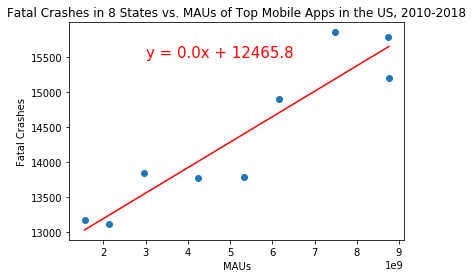

In [29]:
# scatter plot of MAUs of mobile apps vs. Fatal Crashes for 5 years (2010-2014)
plt.scatter(x_values,y_values)
plt.xlabel('MAUs')
plt.ylabel('Fatal Crashes')
plt.title('Fatal Crashes in 8 States vs. MAUs of Top Mobile Apps in the US, 2010-2018')
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,(3000000000,15500),fontsize=15,color="red")
plt.plot(x_values,regress_values,"r-")
print(f"R-squared is: {rvalue}")
print(f"p-value is: {pvalue}")
plt.show()

In [30]:
# import and read smartphone adoption datafile
phone_adoption_df = pd.read_csv('smartphone adoption.csv')

#trim years to match crash data years
phone_adoption_trim = phone_adoption_df.drop([9,10,11,12,13])

R-squared is: 0.9003186964685078
p-value is: 0.0009328845788830946


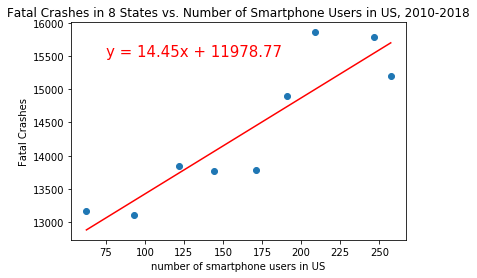

In [31]:
# plot scatterplot and regression line of smartphone users and crash fatalities
x_values2 = phone_adoption_trim['number of smartphone users in US (millions)']
y_values = crashes_per_year
plt.scatter(x_values2,y_values)
plt.title('Fatal Crashes in 8 States vs. Number of Smartphone Users in US, 2010-2018')
plt.xlabel('number of smartphone users in US')
plt.ylabel('Fatal Crashes')
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values2, y_values)
regress_values = x_values2 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,(75,15500),fontsize=15,color="red")
plt.plot(x_values2,regress_values,"r-")
print(f"R-squared is: {rvalue}")
print(f"p-value is: {pvalue}")
plt.show()